In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [4]:
DATASET_ID = 'koumura_bengalese_finch'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'bf.pickle'
df_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/syllable_dfs/koumura_bengalese_finch/bf.pickle')

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,labels,sequence_num,indv,indvi,key,rate,spectrogram
0,1.158,1.249,0,0,Bird3,0,Bird3_322,32000,"[[0, 0, 0, 110, 190, 203, 216, 217, 216, 219, ..."
1,1.323,1.404,0,0,Bird3,0,Bird3_322,32000,"[[0, 0, 0, 54, 164, 182, 187, 191, 196, 196, 1..."
2,1.530,1.564,0,0,Bird3,0,Bird3_322,32000,"[[0, 0, 0, 0, 0, 106, 100, 181, 209, 202, 196,..."


In [9]:
len(syllable_df)

214925

In [10]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### cluster

In [11]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [12]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [13]:
import hdbscan

In [19]:
from avgn.visualization.projections import draw_projection_transitions

Bird5 20525


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/parall

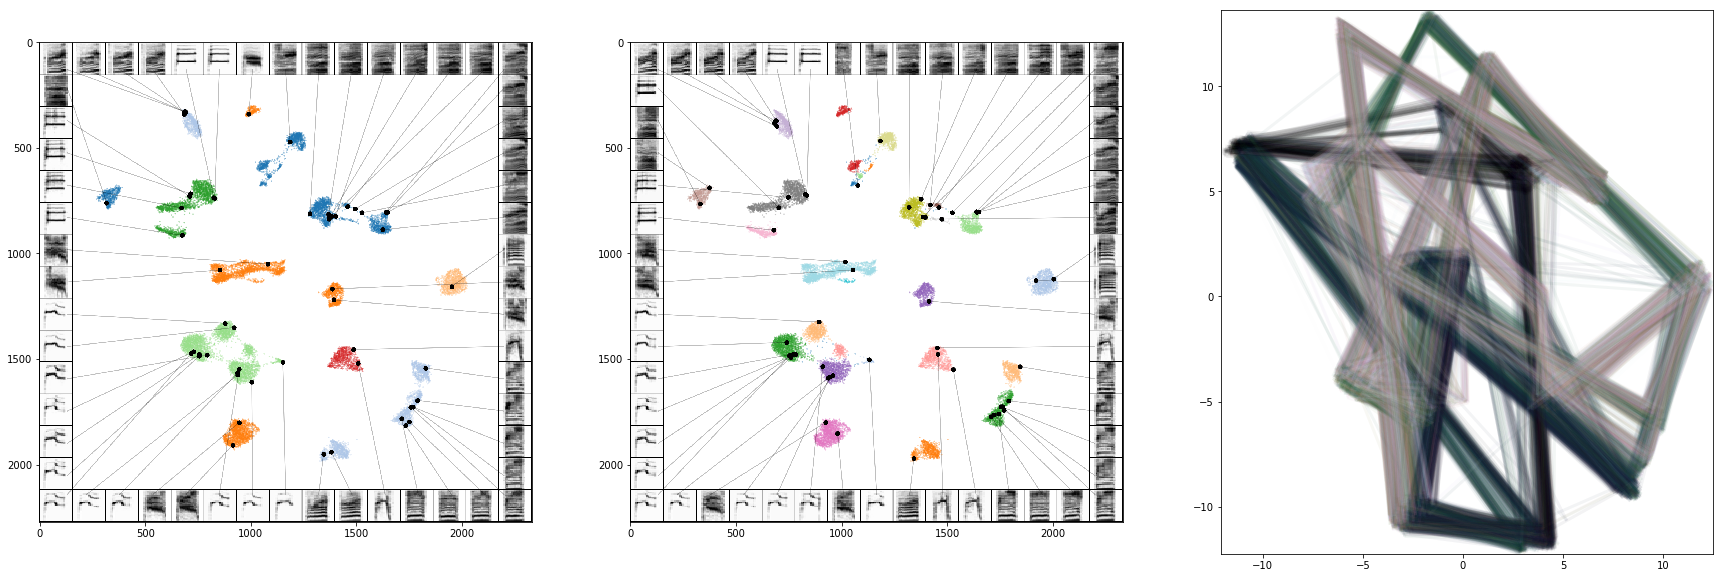

In [22]:
indv_dfs = []
for indv in tqdm(syllable_df.indv.unique()):
    if indv != 'Bird5': continue
    indv_df = syllable_df[syllable_df.indv == indv]
    indv_df = indv_df.sort_values(by=["key", "start_time"])
    print(indv, len(indv_df))
    specs = [norm(i) for i in indv_df.spectrogram.values]
    
    # sequencing
    indv_df["syllables_sequence_id"] = None
    indv_df["syllables_sequence_pos"] = None
    for ki, key in enumerate(indv_df.key.unique()):
        indv_df.loc[indv_df.key == key, "syllables_sequence_id"] = ki
        indv_df.loc[indv_df.key == key, "syllables_sequence_pos"] = np.arange(
            np.sum(indv_df.key == key)
        )
        
    # umap
    specs_flattened = flatten_spectrograms(specs)
    cuml_umap = cumlUMAP(min_dist=0.5)
    z = list(cuml_umap.fit_transform(specs_flattened))
    indv_df["umap"] = z

    #cluster
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=int(len(z) * 0.001), # the smallest size we would expect a cluster to be
        min_samples=1, # larger values = more conservative clustering
    )
    clusterer.fit(z);
    indv_df['hdbscan_labels'] = clusterer.labels_

    indv_dfs.append(indv_df)
    fig, ax = plt.subplots(ncols=3, figsize=(30,10))
    
    draw_projection_transitions(
        projections=np.array(list(indv_df['umap'].values)),
        sequence_ids=indv_df["syllables_sequence_id"],
        sequence_pos=indv_df["syllables_sequence_pos"],
        ax=ax[2],
    )

    for i, lab in enumerate([indv_df.labels.values, indv_df.hdbscan_labels.values]):
    
        scatter_spec(
            np.vstack(z),
            specs,
            column_size=15,
            #x_range = [-5.5,7],
            #y_range = [-10,10],
            pal_color="hls",
            color_points=False,
            enlarge_points=20,
            figsize=(10, 10),
            scatter_kwargs = {
                'labels': list(lab),
                'alpha':0.25,
                's': 1,
                'show_legend': False
            },
            matshow_kwargs = {
                'cmap': plt.cm.Greys
            },
            line_kwargs = {
                'lw':1,
                'ls':"solid",
                'alpha':0.25,
            },
            draw_lines=True,
            ax= ax[i]
        );
    
    
    plt.show()

    #break